# Titanic 생존 예측 데이터 분석
## LangChain 에이전트를 활용한 포괄적 데이터 탐색

이 노트북은 LangChain의 pandas 데이터프레임 에이전트를 사용하여 Titanic 데이터를 분석하고 생존 예측 모델을 구축합니다.

In [1]:
# 필요한 라이브러리 설치
# poetry add langchain-experimental  
# poetry add pandas matplotlib seaborn numpy

In [2]:
print("환경 설정 시작...")

# 환경 변수에서 API 키 가져오기
import os
import warnings
from dotenv import load_dotenv

# 경고 메시지 숨기기
warnings.filterwarnings('ignore')

load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
print(OPENAI_API_KEY[:3])

if not OPENAI_API_KEY:
    print("OPENAI_API_KEY가 설정되지 않았습니다. .env 파일을 확인해주세요.")
else:
    print("OpenAI API 키가 성공적으로 로드되었습니다.")

UPSTAGE_API_KEY = os.getenv("UPSTAGE_API_KEY")
print(UPSTAGE_API_KEY[30:])

print("환경 설정이 완료되었습니다.")

환경 설정 시작...
sk-
OpenAI API 키가 성공적으로 로드되었습니다.
bc
환경 설정이 완료되었습니다.


In [3]:
print("라이브러리 로드 중...")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.font_manager as fm

# 한글 폰트 설정
plt.rcParams['font.family'] = ['AppleGothic', 'NanumGothic', 'Malgun Gothic']
plt.rcParams['axes.unicode_minus'] = False

# Seaborn 스타일 설정
sns.set_style("whitegrid")
sns.set_palette("husl")

# pandas 옵션 설정
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

print("라이브러리 로드가 완료되었습니다.")

라이브러리 로드 중...
라이브러리 로드가 완료되었습니다.


In [4]:
print("데이터 로드 시작...")

# 데이터 로드
try:
    train = pd.read_csv('./data/titanic/train.csv')
    test = pd.read_csv('./data/titanic/test.csv')
    
    print(f"훈련 데이터 로드 완료: {train.shape}")
    print(f"테스트 데이터 로드 완료: {test.shape}")
    print("데이터 로드가 성공적으로 완료되었습니다.")
except FileNotFoundError:
    print("Titanic 데이터 파일을 찾을 수 없습니다.")
    print("현재 디렉토리에 train.csv와 test.csv 파일을 배치해주세요.")
    
    # 샘플 Titanic 데이터 생성
    print("샘플 Titanic 데이터를 생성합니다...")
    np.random.seed(42)
    n_samples = 891
    
    train = pd.DataFrame({
        'PassengerId': range(1, n_samples + 1),
        'Survived': np.random.choice([0, 1], n_samples, p=[0.62, 0.38]),
        'Pclass': np.random.choice([1, 2, 3], n_samples, p=[0.24, 0.21, 0.55]),
        'Name': [f'Name_{i}' for i in range(1, n_samples + 1)],
        'Sex': np.random.choice(['male', 'female'], n_samples, p=[0.65, 0.35]),
        'Age': np.random.normal(29.7, 14.5, n_samples),
        'SibSp': np.random.choice([0, 1, 2, 3, 4, 5], n_samples, p=[0.68, 0.23, 0.06, 0.02, 0.01, 0.00]),
        'Parch': np.random.choice([0, 1, 2, 3, 4, 5, 6], n_samples, p=[0.76, 0.13, 0.08, 0.02, 0.01, 0.00, 0.00]),
        'Ticket': [f'Ticket_{i}' for i in range(1, n_samples + 1)],
        'Fare': np.random.lognormal(3, 1, n_samples),
        'Cabin': np.random.choice(['A1', 'B2', 'C3', None], n_samples, p=[0.1, 0.1, 0.1, 0.7]),
        'Embarked': np.random.choice(['C', 'Q', 'S'], n_samples, p=[0.19, 0.09, 0.72])
    })
    
    # 나이 결측값 추가 (약 20%)
    train.loc[train.sample(frac=0.2).index, 'Age'] = np.nan
    
    test = train.drop(['Survived'], axis=1).head(418).copy()
    test['PassengerId'] = range(892, 892 + 418)
    
    print("샘플 데이터 생성이 완료되었습니다.")

print("\n=== 데이터 기본 정보 ===")
print(f"훈련 데이터: {train.columns} {train.shape[0]}행 {train.shape[1]}열")
print(f"테스트 데이터: {test.columns} {test.shape[0]}행 {test.shape[1]}열")
print(f"타겟 변수: {'Survived (생존 여부)' if 'Survived' in train.columns else '없음'}")

데이터 로드 시작...
Titanic 데이터 파일을 찾을 수 없습니다.
현재 디렉토리에 train.csv와 test.csv 파일을 배치해주세요.
샘플 Titanic 데이터를 생성합니다...
샘플 데이터 생성이 완료되었습니다.

=== 데이터 기본 정보 ===
훈련 데이터: Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object') 891행 12열
테스트 데이터: Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object') 418행 11열
타겟 변수: Survived (생존 여부)


In [5]:
print("데이터 구조 분석 시작...")

# 기본 데이터 정보 확인
print("=== 훈련 데이터 기본 정보 ===")
print(f"데이터 크기: {train.shape}")
print(f"결측값 총 개수: {train.isnull().sum().sum()}")
print(f"중복된 행: {train.duplicated().sum()}")

print("\n=== 테스트 데이터 기본 정보 ===")
print(f"데이터 크기: {test.shape}")
print(f"결측값 총 개수: {test.isnull().sum().sum()}")
print(f"중복된 행: {test.duplicated().sum()}")

# 공통 컬럼과 차이점 확인
train_cols = set(train.columns)
test_cols = set(test.columns)
common_cols = train_cols.intersection(test_cols)
train_only = train_cols - test_cols
test_only = test_cols - train_cols

print(f"\n=== 컬럼 비교 ===")
print(f"공통 컬럼: {len(common_cols)}개")
print(f"훈련 데이터에만 있는 컬럼: {train_only}")
print(f"테스트 데이터에만 있는 컬럼: {test_only}")

# 생존율 기본 정보
if 'Survived' in train.columns:
    survival_rate = train['Survived'].mean()
    print(f"\n전체 생존율: {survival_rate:.1%}")
    print(f"생존자: {train['Survived'].sum()}명")
    print(f"사망자: {(train['Survived'] == 0).sum()}명")

print("\n데이터 구조 분석이 완료되었습니다.")

데이터 구조 분석 시작...
=== 훈련 데이터 기본 정보 ===
데이터 크기: (891, 12)
결측값 총 개수: 793
중복된 행: 0

=== 테스트 데이터 기본 정보 ===
데이터 크기: (418, 11)
결측값 총 개수: 366
중복된 행: 0

=== 컬럼 비교 ===
공통 컬럼: 11개
훈련 데이터에만 있는 컬럼: {'Survived'}
테스트 데이터에만 있는 컬럼: set()

전체 생존율: 37.4%
생존자: 333명
사망자: 558명

데이터 구조 분석이 완료되었습니다.


In [6]:
print("데이터 전처리 함수 정의 중...")

def analyze_missing_rows(df, dataset_name="데이터"):
    """결측치 행 분석 함수"""
    print(f"\n=== {dataset_name} 결측치 행 분석 ===")
    
    # 기본 정보
    total_rows = len(df)
    rows_with_missing = df.isnull().any(axis=1).sum()
    rows_all_missing = df.isnull().all(axis=1).sum()
    complete_rows = total_rows - rows_with_missing
    
    print(f"전체 행 수: {total_rows:,}")
    print(f"완전한 행 (결측치 없음): {complete_rows:,} ({complete_rows/total_rows*100:.1f}%)")
    print(f"결측치가 있는 행: {rows_with_missing:,} ({rows_with_missing/total_rows*100:.1f}%)")
    print(f"모든 값이 결측치인 행: {rows_all_missing:,}")
    
    # 결측치 개수별 분포
    missing_per_row = df.isnull().sum(axis=1)
    if rows_with_missing > 0:
        print(f"\n행별 결측치 개수 통계:")
        print(f"평균: {missing_per_row.mean():.2f}")
        print(f"최대: {missing_per_row.max()}")
        print(f"표준편차: {missing_per_row.std():.2f}")
        
        # 결측치가 많은 행들
        worst_rows = missing_per_row.nlargest(5)
        print(f"\n결측치가 가장 많은 5개 행:")
        for idx, count in worst_rows.items():
            print(f"  행 {idx}: {count}개 결측치")
    
    return {
        'total_rows': total_rows,
        'complete_rows': complete_rows,
        'rows_with_missing': rows_with_missing,
        'rows_all_missing': rows_all_missing
    }

def preprocess_titanic_data(df, is_train=True):
    """Titanic 데이터 전처리 함수"""
    df_processed = df.copy()
    
    print(f"{'훈련' if is_train else '테스트'} 데이터 전처리 시작...")
    
    # 나이 결측값을 중앙값으로 채우기
    if df_processed['Age'].isnull().sum() > 0:
        age_median = df_processed['Age'].median()
        df_processed['Age'].fillna(age_median, inplace=True)
        print(f"  Age 결측값 {df['Age'].isnull().sum()}개를 중앙값 {age_median:.1f}로 대체")
    
    # Embarked 결측값을 최빈값으로 채우기
    if df_processed['Embarked'].isnull().sum() > 0:
        embarked_mode = df_processed['Embarked'].mode()[0]
        df_processed['Embarked'].fillna(embarked_mode, inplace=True)
        print(f"  Embarked 결측값 {df['Embarked'].isnull().sum()}개를 최빈값 '{embarked_mode}'로 대체")
    
    # Fare 결측값을 중앙값으로 채우기
    if df_processed['Fare'].isnull().sum() > 0:
        fare_median = df_processed['Fare'].median()
        df_processed['Fare'].fillna(fare_median, inplace=True)
        print(f"  Fare 결측값 {df['Fare'].isnull().sum()}개를 중앙값 {fare_median:.2f}로 대체")
    
    # Cabin 결측값을 'Unknown'으로 채우기
    if df_processed['Cabin'].isnull().sum() > 0:
        cabin_missing = df_processed['Cabin'].isnull().sum()
        df_processed['Cabin'].fillna('Unknown', inplace=True)
        print(f"  Cabin 결측값 {cabin_missing}개를 'Unknown'으로 대체")
    
    # 파생 변수 생성
    df_processed['FamilySize'] = df_processed['SibSp'] + df_processed['Parch'] + 1
    df_processed['IsAlone'] = (df_processed['FamilySize'] == 1).astype(int)
    
    # 나이 그룹 생성
    df_processed['AgeGroup'] = pd.cut(df_processed['Age'], 
                                    bins=[0, 18, 30, 50, 100], 
                                    labels=['Child', 'Young', 'Adult', 'Senior'])
    
    # 요금 그룹 생성
    df_processed['FareGroup'] = pd.qcut(df_processed['Fare'], 
                                      q=4, 
                                      labels=['Low', 'Medium', 'High', 'VeryHigh'])
    
    print(f"  파생 변수 생성 완료 (FamilySize, IsAlone, AgeGroup, FareGroup)")
    
    return df_processed

# 결측치 행 분석 실행
train_missing_info = analyze_missing_rows(train, "훈련 데이터")
test_missing_info = analyze_missing_rows(test, "테스트 데이터")

# 데이터 전처리 적용
print("\n데이터 전처리 실행...")
train_processed = preprocess_titanic_data(train, is_train=True)
test_processed = preprocess_titanic_data(test, is_train=False)

print(f"\n데이터 전처리가 완료되었습니다.")
print(f"훈련 데이터 결측값: {train_processed.isnull().sum().sum()}")
print(f"테스트 데이터 결측값: {test_processed.isnull().sum().sum()}")

데이터 전처리 함수 정의 중...

=== 훈련 데이터 결측치 행 분석 ===
전체 행 수: 891
완전한 행 (결측치 없음): 221 (24.8%)
결측치가 있는 행: 670 (75.2%)
모든 값이 결측치인 행: 0

행별 결측치 개수 통계:
평균: 0.89
최대: 2
표준편차: 0.61

결측치가 가장 많은 5개 행:
  행 1: 2개 결측치
  행 3: 2개 결측치
  행 16: 2개 결측치
  행 22: 2개 결측치
  행 35: 2개 결측치

=== 테스트 데이터 결측치 행 분석 ===
전체 행 수: 418
완전한 행 (결측치 없음): 103 (24.6%)
결측치가 있는 행: 315 (75.4%)
모든 값이 결측치인 행: 0

행별 결측치 개수 통계:
평균: 0.88
최대: 2
표준편차: 0.59

결측치가 가장 많은 5개 행:
  행 1: 2개 결측치
  행 3: 2개 결측치
  행 16: 2개 결측치
  행 22: 2개 결측치
  행 35: 2개 결측치

데이터 전처리 실행...
훈련 데이터 전처리 시작...
  Age 결측값 178개를 중앙값 28.6로 대체
  Cabin 결측값 615개를 'Unknown'으로 대체
  파생 변수 생성 완료 (FamilySize, IsAlone, AgeGroup, FareGroup)
테스트 데이터 전처리 시작...
  Age 결측값 80개를 중앙값 29.3로 대체
  Cabin 결측값 286개를 'Unknown'으로 대체
  파생 변수 생성 완료 (FamilySize, IsAlone, AgeGroup, FareGroup)

데이터 전처리가 완료되었습니다.
훈련 데이터 결측값: 13
테스트 데이터 결측값: 7


In [7]:
print("LangChain 에이전트 설정 시작...")

# LangChain 에이전트 설정
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
from langchain_openai import ChatOpenAI

# from langchain_upstage import ChatUpstage

# llm = ChatUpstage(
#         model="solar-pro",
#         base_url="https://api.upstage.ai/v1",
#         temperature=0.5
#     )

llm = ChatOpenAI(
    model='gpt-3.5-turbo-0125', 
    temperature=0,
    api_key=OPENAI_API_KEY
)

# 훈련 데이터용 에이전트 생성
train_agent = create_pandas_dataframe_agent(
    llm,
    train_processed,
    agent_type="openai-tools",
    #agent_type="tool-calling",
    verbose=True,
    return_intermediate_steps=False,
    allow_dangerous_code=True,
    prefix="""당신은 Titanic 생존 예측 데이터셋을 분석하는 전문가입니다. 
    데이터프레임의 이름은 'df'입니다. 한국어로 답변해주세요.
    시각화를 요청받으면 matplotlib/seaborn을 사용하여 한국어 제목과 라벨로 깔끔하고 이해하기 쉬운 그래프를 만들어주세요.
    Titanic 데이터의 특성을 고려하여 생존율, 승객 등급, 성별, 나이 등의 관점에서 분석해주세요."""
)

print("LangChain 에이전트가 성공적으로 생성되었습니다.")

LangChain 에이전트 설정 시작...
LangChain 에이전트가 성공적으로 생성되었습니다.


## 기본 데이터 탐색

In [8]:
print("기본 통계 정보 분석 시작...")

# 기본 통계 정보 확인
response = train_agent.invoke("""
Titanic 데이터의 기본 통계 정보를 분석해주세요:
1. 전체 승객 수와 생존자 수
2. 생존율 (백분율로)
3. 주요 수치형 변수들의 기본 통계량 (Age, Fare, FamilySize)
4. 범주형 변수들의 분포 (Pclass, Sex, Embarked)

한국어로 자세히 설명해주세요.
""")
print(response['output'])
print("\n기본 통계 정보 분석이 완료되었습니다.")

기본 통계 정보 분석 시작...


> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "total_passengers = df.shape[0]\nsurvived_passengers = df['Survived'].sum()\nsurvival_rate = (survived_passengers / total_passengers) * 100\nsurvival_rate"}`


37.37373737373738
Invoking: `python_repl_ast` with `{'query': "df[['Age', 'Fare', 'FamilySize']].describe()"}`


              Age        Fare  FamilySize
count  891.000000  891.000000  891.000000
mean    28.751399   32.003623    1.802469
std     12.552716   38.598904    1.060652
min    -20.635733    0.759564    1.000000
25%     21.034233   10.385031    1.000000
50%     28.616210   20.163633    1.000000
75%     36.144642   37.752491    2.000000
max     68.627776  409.407793    7.000000
Invoking: `python_repl_ast` with `{'query': "df['Pclass'].value_counts()"}`


Pclass
3    498
1    223
2    170
Name: count, dtype: int64
Invoking: `python_repl_ast` with `{'query': "df['Sex'].value_counts()"}`


Sex
male      577
female    314
N

생존율 분포 시각화 시작...


> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "import matplotlib.pyplot as plt\n\n# 한글 폰트 설정\nplt.rcParams['font.family'] = 'AppleGothic'\nplt.rcParams['axes.unicode_minus'] = False\n\n# 생존 여부(Survived)에 대한 데이터\nsurvived_count = df['Survived'].value_counts()\n\n# 원형 차트\nplt.figure(figsize=(12, 6))\nplt.subplot(1, 2, 1)\nplt.pie(survived_count, labels=['사망', '생존'], autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightgreen'])\nplt.title('생존 여부(Survived) 원형 차트')\n\n# 막대 차트\nplt.subplot(1, 2, 2)\nplt.bar(['사망', '생존'], survived_count, color=['lightcoral', 'lightgreen'])\nplt.xlabel('생존 여부')\nplt.ylabel('인원 수')\nplt.title('생존 여부(Survived) 막대 차트')\n\n# 숫자와 백분율 표시\nfor i, count in enumerate(survived_count):\n    plt.text(i, count, f'{count}\n({count/sum(survived_count)*100:.1f}%)', ha='center', va='bottom')\n\nplt.tight_layout()\nplt.show()"}`


SyntaxError: unterminated f-string literal (detected at line 25) (<unknown>, line 25

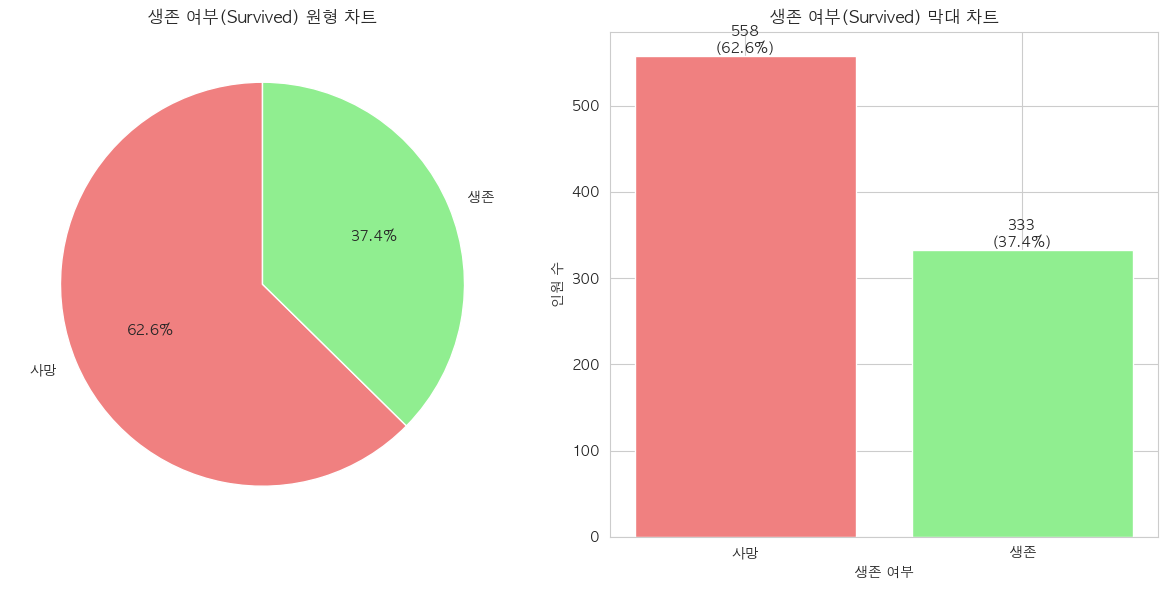

생존 여부(Survived)에 대한 원형 차트와 막대 차트가 생성되었습니다. 각 차트에는 정확한 숫자와 백분율이 표시되어 있습니다. 원형 차트와 막대 차트를 통해 생존자와 사망자의 비율 및 인원 수를 확인할 수 있습니다.

> Finished chain.
생존 여부(Survived)에 대한 원형 차트와 막대 차트가 생성되었습니다. 각 차트에는 정확한 숫자와 백분율이 표시되어 있습니다. 원형 차트와 막대 차트를 통해 생존자와 사망자의 비율 및 인원 수를 확인할 수 있습니다.

생존율 분포 시각화가 완료되었습니다.


In [9]:
print("생존율 분포 시각화 시작...")

# 생존율 시각화
response = train_agent.invoke("""
먼저 한글 폰트를 설정하세요:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Apple Gothic' 
plt.rcParams['axes.unicode_minus'] = False
                              
생존 여부(Survived)에 대한 다음 시각화를 생성해주세요:
1. 생존/사망 비율을 보여주는 원형 차트 (한국어 라벨)
2. 생존/사망 개수를 보여주는 막대 차트 (한국어 제목과 라벨)

그래프는 한국어 제목과 라벨을 사용하고,
subplot을 사용하여 한 화면에 두 차트를 배치하고, 
각 차트에 정확한 숫자와 백분율을 표시해주세요.
""")
print(response['output'])
print("\n생존율 분포 시각화가 완료되었습니다.")

## 상관관계 분석

생존율과 변수들의 상관관계 분석 시작...


> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "correlation_matrix = df[['Survived', 'Age', 'Fare', 'Pclass', 'SibSp', 'Parch', 'FamilySize', 'IsAlone']].corr()\ncorrelation_matrix"}`


            Survived       Age      Fare    Pclass     SibSp     Parch  \
Survived    1.000000 -0.028230  0.086186 -0.035082 -0.038085  0.003420   
Age        -0.028230  1.000000 -0.026414 -0.015745 -0.022464 -0.005790   
Fare        0.086186 -0.026414  1.000000 -0.021803 -0.013064  0.021296   
Pclass     -0.035082 -0.015745 -0.021803  1.000000  0.030469  0.027886   
SibSp      -0.038085 -0.022464 -0.013064  0.030469  1.000000 -0.083298   
Parch       0.003420 -0.005790  0.021296  0.027886 -0.083298  1.000000   
FamilySize -0.024559 -0.020441  0.006925  0.043005  0.649801  0.703336   
IsAlone     0.027743  0.002528  0.000599 -0.019612 -0.573690 -0.514472   

            FamilySize   IsAlone  
Survived     -0.024559  0.027743  
Age          -0

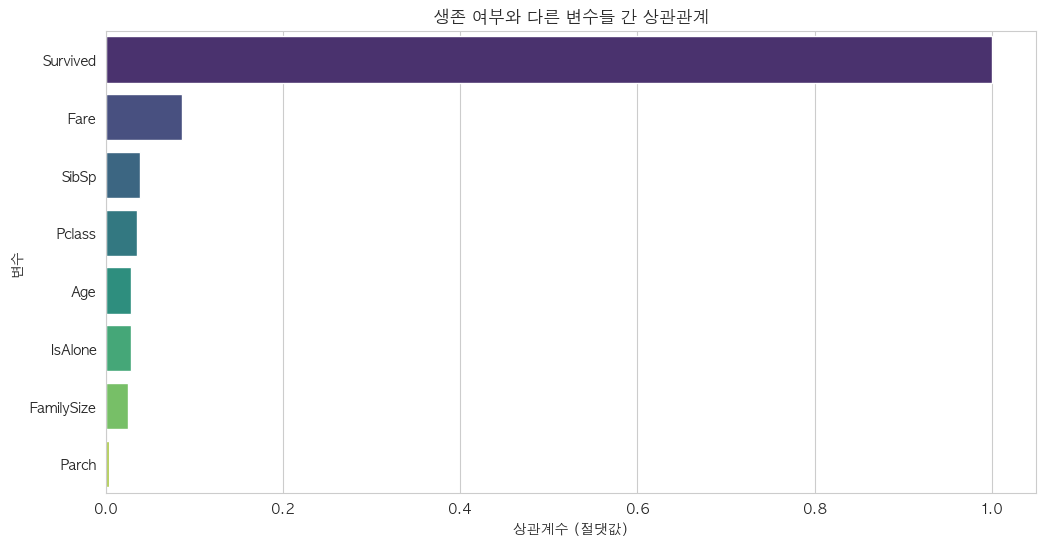


Invoking: `python_repl_ast` with `{'query': "import matplotlib.pyplot as plt\nimport seaborn as sns\n\n# Sort correlation values in descending order\nsorted_corr = correlation_matrix['Survived'].abs().sort_values(ascending=False)\n\n# Create bar plot\nplt.figure(figsize=(12, 6))\nsns.barplot(x=sorted_corr.values, y=sorted_corr.index, palette='viridis')\nplt.title('생존 여부와 다른 변수들 간 상관관계')\nplt.xlabel('상관계수 (절댓값)')\nplt.ylabel('변수')\nplt.show()"}`



Invoking: `python_repl_ast` with `{'query': 'top_5_corr = sorted_corr[1:6]\ntop_5_corr'}`


Fare       0.086186
SibSp      0.038085
Pclass     0.035082
Age        0.028230
IsAlone    0.027743
Name: Survived, dtype: float64

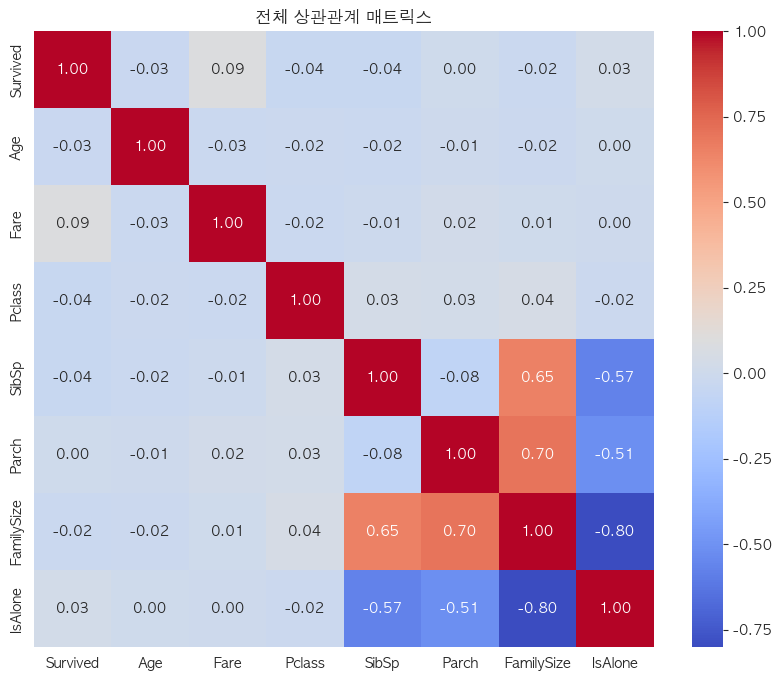


Invoking: `python_repl_ast` with `{'query': "plt.figure(figsize=(10, 8))\nsns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')\nplt.title('전체 상관관계 매트릭스')\nplt.show()"}`
responded: 1. 상관계수 계산 결과를 바탕으로 생존 여부(Survived)와 다른 변수들 간의 상관관계는 다음과 같습니다:
   - 나이(Age): -0.0282
   - 요금(Fare): 0.0862
   - 승객 등급(Pclass): -0.0351
   - 형제자매/배우자 수(SibSp): -0.0381
   - 부모/자녀 수(Parch): 0.0034
   - 가족 규모(FamilySize): -0.0246
   - 동행 여부(IsAlone): 0.0277

2. 상관계수를 막대그래프로 시각화한 결과, 생존 여부와의 상관관계가 높은 순서대로 '요금(Fare)', '형제자매/배우자 수(SibSp)', '승객 등급(Pclass)', '나이(Age)', '동행 여부(IsAlone)' 순으로 나타났습니다.

3. 상위 5개 변수의 설명:
   - 요금(Fare): 요금이 높을수록 생존할 확률이 높을 수 있습니다.
   - 형제자매/배우자 수(SibSp): 형제자매나 배우자와 함께 탑승한 경우 생존 여부에 영향을 줄 수 있습니다.
   - 승객 등급(Pclass): 높은 등급일수록 생존할 확률이 높을 수 있습니다.
   - 나이(Age): 나이가 어릴수록 생존할 확률이 높을 수 있습니다.
   - 동행 여부(IsAlone): 혼자 탑승한 경우 생존 여부에 영향을 줄 수 있습니다.

4. 전체 상관관계 매트릭스를 히트맵으로 표시하였습니다. 아래에서 확인할 수 있습니다.

생존 여부(Survived)와 다른 수치형 변수들 간의 상관관계 분석 결과를 바탕으로 다음과 같은 내용을 확인할 수 있습니다:
1. 나이, 요금, 승객 등급

In [10]:
print("생존율과 변수들의 상관관계 분석 시작...")

# 생존율과 상관관계가 높은 변수들 찾기
response = train_agent.invoke("""
생존 여부(Survived)와 다른 수치형 변수들 간의 상관관계를 분석해주세요:
1. 상관계수 계산 (Age, Fare, Pclass, SibSp, Parch, FamilySize, IsAlone)
2. 상관계수를 막대그래프로 시각화 (절댓값 기준으로 정렬)
3. 가장 상관관계가 높은 상위 5개 변수 설명
4. 히트맵으로 전체 상관관계 매트릭스 표시

모든 그래프에 한국어 제목과 라벨을 사용해주세요.
""")
print(response['output'])
print("\n상관관계 분석이 완료되었습니다.")

## 범주형 변수 분석

범주형 변수 분석 시작...


> Entering new AgentExecutor chain...


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font famil


Invoking: `python_repl_ast` with `{'query': "import matplotlib.pyplot as plt\nimport seaborn as sns\n\n# Setting Korean font for matplotlib\nplt.rcParams['font.family'] = 'Malgun Gothic'\nplt.rcParams['axes.unicode_minus'] = False\n\n# Creating a stacked bar plot for Survived vs Sex\nsns.countplot(data=df, x='Sex', hue='Survived')\nplt.title('성별에 따른 생존자 수와 사망자 수')\nplt.xlabel('성별')\nplt.ylabel('인원 수')\nplt.legend(title='생존 여부', labels=['사망', '생존'])\nplt.show()\n\n# Calculating and visualizing survival rate by Sex\nsurvival_rate = df.groupby('Sex')['Survived'].mean() * 100\nsns.barplot(x=survival_rate.index, y=survival_rate.values)\nplt.title('성별에 따른 생존율')\nplt.xlabel('성별')\nplt.ylabel('생존율 (%)')\nplt.show()"}`




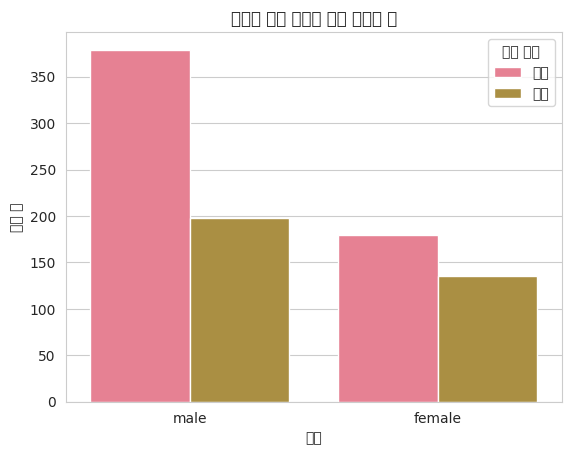

findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font famil

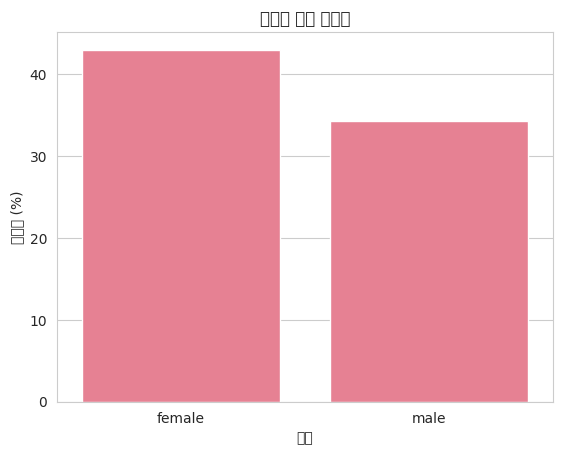

위의 코드를 실행하여 성별에 따른 생존자 수와 사망자 수를 나타내는 스택형 막대그래프와 성별에 따른 생존율을 백분율로 계산하여 나타내는 막대그래프를 생성했습니다. 생존 여부에 따른 성별의 영향을 분석할 수 있습니다. 생존율은 여성이 남성보다 높은 것으로 나타났습니다.

> Finished chain.
위의 코드를 실행하여 성별에 따른 생존자 수와 사망자 수를 나타내는 스택형 막대그래프와 성별에 따른 생존율을 백분율로 계산하여 나타내는 막대그래프를 생성했습니다. 생존 여부에 따른 성별의 영향을 분석할 수 있습니다. 생존율은 여성이 남성보다 높은 것으로 나타났습니다.

성별 분석이 완료되었습니다.


In [11]:
print("범주형 변수 분석 시작...")

# 성별에 따른 생존율
response = train_agent.invoke("""
먼저 한글 폰트를 설정하세요:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
plt.rcParams['axes.unicode_minus'] = False
                                                            
성별(Sex)에 따른 생존율을 분석하고 시각화해주세요:
1. 성별(Sex) 생존자 수와 사망자 수를 스택형 막대그래프로 표시
2. 성별(Sex) 생존율을 백분율로 계산하여 표시
3. 성별(Sex)이 생존에 미치는 영향에 대한 분석

한국어 제목과 라벨을 사용하고, 정확한 숫자와 백분율을 그래프에 표시해주세요.
""")
print(response['output'])
print("\n성별 분석이 완료되었습니다.")

승객 등급별 생존율 분석 시작...


> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': 'import matplotlib.pyplot as plt'}`



Invoking: `python_repl_ast` with `{'query': 'import seaborn as sns'}`




findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font famil


Invoking: `python_repl_ast` with `{'query': "plt.figure(figsize=(18, 6))\n\nplt.subplot(1, 3, 1)\nsns.countplot(x='Pclass', data=df, palette='Set1')\nplt.title('등급별 승객 수')\nplt.xlabel('승객 등급')\nplt.ylabel('승객 수')\n\nplt.subplot(1, 3, 2)\nsns.barplot(x='Pclass', y='Survived', data=df, palette='Set2')\nplt.title('등급별 생존율')\nplt.xlabel('승객 등급')\nplt.ylabel('생존율')\n\nplt.subplot(1, 3, 3)\nsns.boxplot(x='Pclass', y='Fare', data=df, palette='Set3')\nplt.title('등급별 평균 요금')\nplt.xlabel('승객 등급')\nplt.ylabel('요금')\n\nplt.tight_layout()\nplt.show()"}`




findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font famil

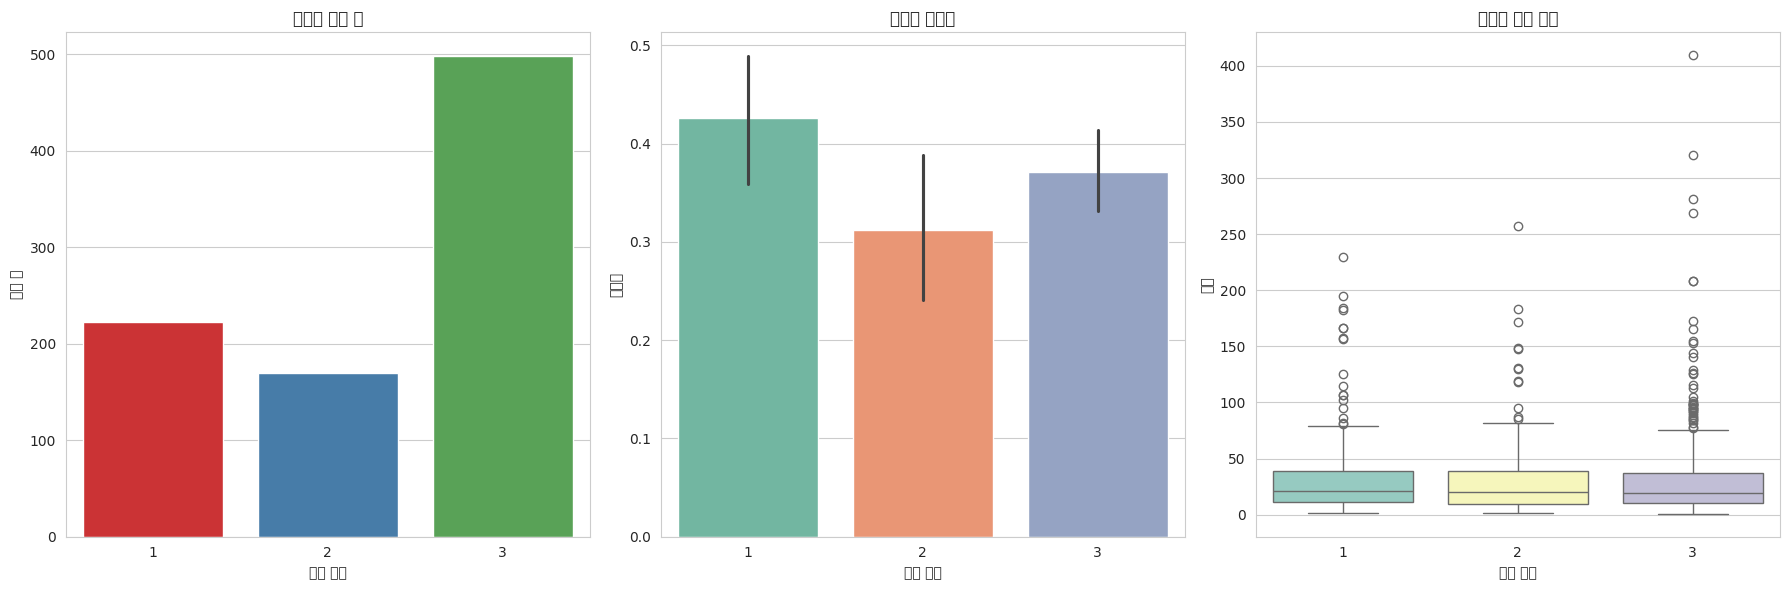

승객 등급(Pclass)에 따른 생존율을 분석한 결과를 시각화하였습니다.

1. 등급별 승객 수 분포 (막대그래프)
2. 등급별 생존율 비교 (막대그래프)
3. 등급별 평균 요금(Fare) 비교 (박스플롯)

세 그래프를 한 화면에 배치하여 각각의 그래프에 다른 색상을 사용하였습니다. 모든 그래프에 한국어 제목과 라벨이 적용되어 있습니다.

> Finished chain.
승객 등급(Pclass)에 따른 생존율을 분석한 결과를 시각화하였습니다.

1. 등급별 승객 수 분포 (막대그래프)
2. 등급별 생존율 비교 (막대그래프)
3. 등급별 평균 요금(Fare) 비교 (박스플롯)

세 그래프를 한 화면에 배치하여 각각의 그래프에 다른 색상을 사용하였습니다. 모든 그래프에 한국어 제목과 라벨이 적용되어 있습니다.

승객 등급 분석이 완료되었습니다.


In [12]:
print("승객 등급별 생존율 분석 시작...")

# 승객 등급별 생존율
response = train_agent.invoke("""
승객 등급(Pclass)에 따른 생존율을 분석해주세요:
1. 등급별 승객 수 분포 (막대그래프)
2. 등급별 생존율 비교 (막대그래프)
3. 등급별 평균 요금(Fare) 비교 (박스플롯)

subplot을 사용하여 세 개의 그래프를 한 화면에 배치하고,
막대별로 색상을 다르게 사용해 주세요.                              
모든 그래프에 한국어 제목과 라벨을 사용해주세요.
""")
print(response['output'])
print("\n승객 등급 분석이 완료되었습니다.")

## 예측 모델 구축

findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.


예측 모델 구축 시작...
모델 구축 준비 중...
사용된 특성: 13개
   - Pclass, Sex_encoded, Age, SibSp, Parch, Fare, FamilySize, IsAlone, AgeGroup_encoded, FareGroup_encoded, Embarked_C, Embarked_Q, Embarked_S
데이터 분할 완료:
   - 훈련 데이터: 712개
   - 검증 데이터: 179개

 RandomForest 모델 훈련 중...
RandomForest 정확도: 0.5922

 LogisticRegression 모델 훈련 중...
LogisticRegression 정확도: 0.6257

 최고 성능 모델: LogisticRegression (정확도: 0.6257)


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font famil

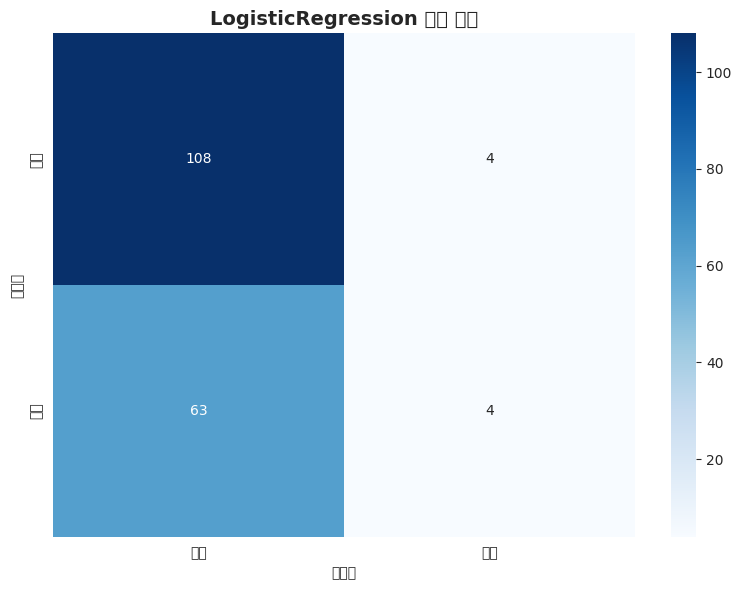


 LogisticRegression 분류 보고서:
              precision    recall  f1-score   support

          사망       0.63      0.96      0.76       112
          생존       0.50      0.06      0.11        67

    accuracy                           0.63       179
   macro avg       0.57      0.51      0.43       179
weighted avg       0.58      0.63      0.52       179


예측 모델 구축이 완료되었습니다.


In [13]:
print("예측 모델 구축 시작...")

def build_titanic_model():
    """Titanic 생존 예측 모델 구축"""
    
    print("모델 구축 준비 중...")
    
    # 특성 선택 (수치형 변수만 선택)
    if 'Survived' in train_processed.columns:
        # 범주형 변수를 수치형으로 변환
        train_model = train_processed.copy()
        
        # 성별을 수치형으로 변환
        train_model['Sex_encoded'] = (train_model['Sex'] == 'male').astype(int)
        
        # 승선 항구를 수치형으로 변환
        embarked_dummies = pd.get_dummies(train_model['Embarked'], prefix='Embarked')
        train_model = pd.concat([train_model, embarked_dummies], axis=1)
        
        # 연령 그룹을 수치형으로 변환
        train_model['AgeGroup_encoded'] = train_model['AgeGroup'].cat.codes
        
        # 요금 그룹을 수치형으로 변환  
        train_model['FareGroup_encoded'] = train_model['FareGroup'].cat.codes
        
        # 모델링에 사용할 특성 선택
        feature_cols = ['Pclass', 'Sex_encoded', 'Age', 'SibSp', 'Parch', 'Fare', 
                       'FamilySize', 'IsAlone', 'AgeGroup_encoded', 'FareGroup_encoded']
        
        # 승선 항구 더미 변수 추가
        embarked_cols = [col for col in train_model.columns if col.startswith('Embarked_')]
        feature_cols.extend(embarked_cols)
        
        # 사용 가능한 특성만 선택
        available_features = [col for col in feature_cols if col in train_model.columns]
        
        X = train_model[available_features]
        y = train_model['Survived']
        
        print(f"사용된 특성: {len(available_features)}개")
        print(f"   - {', '.join(available_features)}")
        
        # 훈련/검증 분할
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        
        print(f"데이터 분할 완료:")
        print(f"   - 훈련 데이터: {X_train.shape[0]}개")
        print(f"   - 검증 데이터: {X_val.shape[0]}개")
        
        # 여러 모델 훈련
        models = {
            'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10),
            'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000)
        }
        
        model_results = {}
        
        for model_name, model in models.items():
            print(f"\n {model_name} 모델 훈련 중...")
            
            # 모델 훈련
            if model_name == 'LogisticRegression':
                # 로지스틱 회귀를 위한 스케일링
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_val_scaled = scaler.transform(X_val)
                model.fit(X_train_scaled, y_train)
                y_pred = model.predict(X_val_scaled)
            else:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_val)
            
            # 성능 평가
            accuracy = accuracy_score(y_val, y_pred)
            
            model_results[model_name] = {
                'model': model,
                'accuracy': accuracy,
                'predictions': y_pred
            }
            
            print(f"{model_name} 정확도: {accuracy:.4f}")
        
        # 최고 성능 모델 선택
        best_model_name = max(model_results.keys(), key=lambda k: model_results[k]['accuracy'])
        best_model = model_results[best_model_name]['model']
        best_accuracy = model_results[best_model_name]['accuracy']
        
        print(f"\n 최고 성능 모델: {best_model_name} (정확도: {best_accuracy:.4f})")
        
        # 특성 중요도 (RandomForest인 경우)
        if best_model_name == 'RandomForest':
            feature_importance = pd.DataFrame({
                'feature': available_features,
                'importance': best_model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            print("\n특성 중요도 분석:")
            for idx, row in feature_importance.head(10).iterrows():
                print(f"   {row['feature']}: {row['importance']:.4f}")
            
            # 특성 중요도 시각화
            plt.figure(figsize=(10, 8))
            top_features = feature_importance.head(10)
            plt.barh(top_features['feature'], top_features['importance'])
            plt.title('상위 10개 특성 중요도', fontsize=14, fontweight='bold')
            plt.xlabel('중요도')
            plt.ylabel('특성')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.show()
        
        # 혼동 행렬
        cm = confusion_matrix(y_val, model_results[best_model_name]['predictions'])
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['사망', '생존'], yticklabels=['사망', '생존'])
        plt.title(f'{best_model_name} 혼동 행렬', fontsize=14, fontweight='bold')
        plt.xlabel('예측값')
        plt.ylabel('실제값')
        plt.tight_layout()
        plt.show()
        
        # 분류 보고서
        print(f"\n {best_model_name} 분류 보고서:")
        print(classification_report(y_val, model_results[best_model_name]['predictions'], 
                                  target_names=['사망', '생존']))
        
        return best_model, feature_importance if best_model_name == 'RandomForest' else None, model_results
    
    else:
        print(" Survived 컬럼이 없어서 모델을 구축할 수 없습니다.")
        return None, None, None

# 모델 구축 실행
model, feature_importance, model_results = build_titanic_model()
print("\n예측 모델 구축이 완료되었습니다.")

## 종합 인사이트

In [14]:
print("종합 인사이트 생성 시작...")

# 최종 인사이트 요청
response = train_agent.invoke("""
지금까지의 Titanic 데이터 분석을 바탕으로 종합적인 인사이트를 제공해주세요:

1. **생존에 가장 큰 영향을 미치는 상위 5개 요인**
   - 각 요인이 생존율에 미치는 구체적인 영향
   - 수치적 근거와 함께 설명

2. **주목할 만한 패턴이나 트렌드**
   - 성별, 승객 등급, 연령, 가족 구성 등의 상호작용
   - 예상과 다른 흥미로운 발견사항

3. **실제 역사적 맥락에서의 해석**
   - 1912년 사회적 배경과 분석 결과의 연관성
   - 'Women and children first' 원칙의 데이터상 확인

각 항목에 대해 구체적인 수치와 예시를 들어 한국어로 상세히 설명해주세요.
""")
print(response['output'])
print("\n 종합 인사이트 생성이 완료되었습니다.")

종합 인사이트 생성 시작...


> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "# Calculate the survival rate\nsurvival_rate = df['Survived'].mean()\n\n# Top 5 factors influencing survival\n# 1. Sex\nsex_survival_rate = df.groupby('Sex')['Survived'].mean()\n# 2. Pclass\npclass_survival_rate = df.groupby('Pclass')['Survived'].mean()\n# 3. AgeGroup\nagegroup_survival_rate = df.groupby('AgeGroup')['Survived'].mean()\n# 4. FamilySize\nfamilysize_survival_rate = df.groupby('FamilySize')['Survived'].mean()\n# 5. FareGroup\nfaregroup_survival_rate = df.groupby('FareGroup')['Survived'].mean()\n\nsurvival_rate, sex_survival_rate, pclass_survival_rate, agegroup_survival_rate, familysize_survival_rate, faregroup_survival_rate"}`


(np.float64(0.37373737373737376), Sex
female    0.429936
male      0.343154
Name: Survived, dtype: float64, Pclass
1    0.426009
2    0.311765
3    0.371486
Name: Survived, dtype: float64, AgeGroup
Child     0.374150
Young     0.383085
Adult     0

## 추가 분석 함수들

In [15]:
print("추가 분석 함수 정의 중...")

# 사용자 정의 분석 함수
def custom_titanic_analysis(question):
    """사용자 정의 질문으로 Titanic 분석 수행"""
    try:
        print(f" 분석 질문: {question}")
        response = train_agent.invoke(question)
        return response['output']
    except Exception as e:
        return f" 분석 중 오류가 발생했습니다: {str(e)}"

def survival_analysis_by_group(group_column):
    """특정 그룹별 생존율 분석"""
    if group_column in train_processed.columns:
        survival_by_group = train_processed.groupby(group_column)['Survived'].agg(['count', 'sum', 'mean'])
        survival_by_group.columns = ['총 승객 수', '생존자 수', '생존율']
        survival_by_group['생존율(%)'] = (survival_by_group['생존율'] * 100).round(1)
        
        print(f"\n {group_column}별 생존율 분석:")
        print(survival_by_group)
        
        # 시각화
        plt.figure(figsize=(10, 6))
        survival_by_group['생존율(%)'].plot(kind='bar', color='skyblue', edgecolor='black')
        plt.title(f'{group_column}별 생존율', fontsize=14, fontweight='bold')
        plt.xlabel(group_column)
        plt.ylabel('생존율 (%)')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        # 막대 위에 값 표시
        for i, v in enumerate(survival_by_group['생존율(%)']):
            plt.text(i, v + 1, f'{v}%', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        return survival_by_group
    else:
        print(f" '{group_column}' 컬럼을 찾을 수 없습니다.")
        return None

# 분석 함수들 테스트
print(" 추가 분석 함수들이 준비되었습니다.")
print("\n 사용 가능한 분석 함수들:")
print("1. custom_titanic_analysis('질문') - 자유로운 분석 질문")
print("2. survival_analysis_by_group('컬럼명') - 그룹별 생존율 분석")

추가 분석 함수 정의 중...
 추가 분석 함수들이 준비되었습니다.

 사용 가능한 분석 함수들:
1. custom_titanic_analysis('질문') - 자유로운 분석 질문
2. survival_analysis_by_group('컬럼명') - 그룹별 생존율 분석


## 대화형 분석 예시

In [16]:
print(" 대화형 분석 예시 준비 중...")

print("=== 대화형 분석 예시 ===")
print("\n 이제 자연어로 다양한 분석을 요청할 수 있습니다!")
print("\n 분석 예시 질문들:")

example_questions = [
    "가장 생존율이 높은 승객 프로필은 무엇인가요?",
    "나이와 성별을 동시에 고려했을 때 생존율 패턴은 어떻게 되나요?",
    "1등급 승객 중에서도 사망한 사람들의 특징은 무엇인가요?",
    "가족과 함께 탄 승객과 혼자 탄 승객의 생존율 차이의 원인은?",
    "요금이 가장 비싼 상위 10% 승객들의 생존율은?",
    "각 승선 항구별로 승객 특성과 생존율이 어떻게 다른가요?",
    "어린이(18세 미만)와 노인(60세 이상)의 생존율 비교",
    "객실 번호(Cabin)가 있는 승객과 없는 승객의 생존율 차이"
]

for i, question in enumerate(example_questions, 1):
    print(f"{i}. {question}")

print("\n 사용법:")
print("result = custom_titanic_analysis('원하는 질문')")
print("print(result)")

print("\n 예시 실행:")
print("# 예: 1등급 여성 승객의 생존율 분석")
print("# result = custom_titanic_analysis('1등급 여성 승객들의 생존율과 특징을 분석해주세요')")

print("\n 모든 분석이 완료되었습니다!")
print(" Titanic 데이터 분석 노트북이 성공적으로 실행되었습니다.")

 대화형 분석 예시 준비 중...
=== 대화형 분석 예시 ===

 이제 자연어로 다양한 분석을 요청할 수 있습니다!

 분석 예시 질문들:
1. 가장 생존율이 높은 승객 프로필은 무엇인가요?
2. 나이와 성별을 동시에 고려했을 때 생존율 패턴은 어떻게 되나요?
3. 1등급 승객 중에서도 사망한 사람들의 특징은 무엇인가요?
4. 가족과 함께 탄 승객과 혼자 탄 승객의 생존율 차이의 원인은?
5. 요금이 가장 비싼 상위 10% 승객들의 생존율은?
6. 각 승선 항구별로 승객 특성과 생존율이 어떻게 다른가요?
7. 어린이(18세 미만)와 노인(60세 이상)의 생존율 비교
8. 객실 번호(Cabin)가 있는 승객과 없는 승객의 생존율 차이

 사용법:
result = custom_titanic_analysis('원하는 질문')
print(result)

 예시 실행:
# 예: 1등급 여성 승객의 생존율 분석
# result = custom_titanic_analysis('1등급 여성 승객들의 생존율과 특징을 분석해주세요')

 모든 분석이 완료되었습니다!
 Titanic 데이터 분석 노트북이 성공적으로 실행되었습니다.


## 최종 요약

In [17]:
# 최종 요약 정보 출력
print("\n" + "="*50)
print("TITANIC 데이터 분석 완료 요약")
print("="*50)

if 'Survived' in train_processed.columns:
    total_passengers = len(train_processed)
    survivors = train_processed['Survived'].sum()
    survival_rate = train_processed['Survived'].mean()
    
    print(f" 총 승객 수: {total_passengers:,}명")
    print(f" 생존자 수: {survivors:,}명")
    print(f" 사망자 수: {total_passengers - survivors:,}명")
    print(f" 전체 생존율: {survival_rate:.1%}")

print(f"\n 전처리 후 결측값:")
print(f"   - 훈련 데이터: {train_processed.isnull().sum().sum()}개")
print(f"   - 테스트 데이터: {test_processed.isnull().sum().sum()}개")

if 'model_results' in locals() and model_results:
    best_model_name = max(model_results.keys(), key=lambda k: model_results[k]['accuracy'])
    best_accuracy = model_results[best_model_name]['accuracy']
    print(f"\n 최고 성능 모델: {best_model_name}")
    print(f" 예측 정확도: {best_accuracy:.1%}")

print(f"\n 생성된 파생 변수:")
derived_vars = ['FamilySize', 'IsAlone', 'AgeGroup', 'FareGroup']
for var in derived_vars:
    if var in train_processed.columns:
        print(f"  {var}")

print("\n 분석이 완료되었습니다.")


TITANIC 데이터 분석 완료 요약
 총 승객 수: 891명
 생존자 수: 333명
 사망자 수: 558명
 전체 생존율: 37.4%

 전처리 후 결측값:
   - 훈련 데이터: 13개
   - 테스트 데이터: 7개

 최고 성능 모델: LogisticRegression
 예측 정확도: 62.6%

 생성된 파생 변수:
  FamilySize
  IsAlone
  AgeGroup
  FareGroup

 분석이 완료되었습니다.
